In [86]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from PIL import Image
import json

# expects fretboard dataset to be in data folder on same level as tabs_generator folder
train_str = "train" # change to train or test to perform on respective data
dataset_path = "../data/fretboard_dataset/"
images_path = f"../data/fretboard_dataset/fretboard_frames_{train_str}/"
json_fn = os.path.join(dataset_path, f"fretboard_labels_{train_str}_vgg.json")
fns = os.listdir(images_path)
image_fns = [fn for fn in fns if not "annotated" in fn]
fn = image_fns[0]

f = open(json_fn)
data = json.load(f) # data is dict of json contents

x_list = data[fn]["regions"]["0"]["shape_attributes"]["all_points_x"] # list of rectangle coordinates
y_list = data[fn]["regions"]["0"]["shape_attributes"]["all_points_y"]
x_list.pop(-1) # remove duplicate of first coordinate from end of lists
y_list.pop(-1)

def is_point_inside_polygon(pt, polygon):
    n = len(polygon)
    x = pt[0]
    y = pt[1]
    inside = False

    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
        p1x, p1y = p2x, p2y

    return inside

def get_point_on_line(p1, p2, t):
    return (int((p1 + t * (p2 - p1))[0]), int((p1 + t * (p2 - p1))[1]))


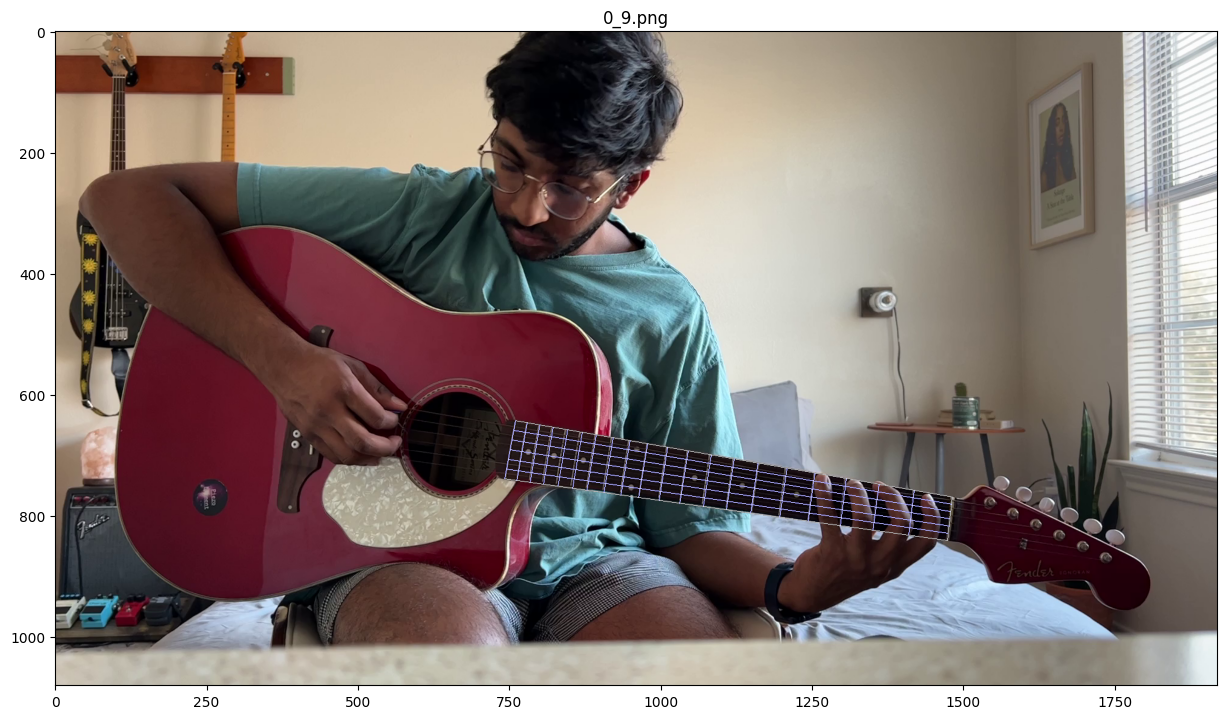

In [87]:
plt.figure(figsize=(15,15))
img = np.asarray(Image.open(os.path.join(images_path, fn)))
corners = np.stack(np.asarray([x_list, y_list], np.int32)).T
corners = corners.reshape((-1,1,2))
top_left = np.array([x_list[0], y_list[0]])
top_right = np.array([x_list[3], y_list[3]])
bot_left = np.array([x_list[1], y_list[1]])
bot_right = np.array([x_list[2], y_list[2]])
cv.polylines(img,[corners],True,(1,0,0))
ratios = np.array([.06, .115, .166, .216 ,.2595, .305, .342, .378, .414, .446, .478, .505, .532, .558, .58, .6031, .6254, .6464, .6663, .685])
ratios /= ratios.max()

for r in ratios:
    top_pt = get_point_on_line(top_right, top_left, r)
    bot_pt = get_point_on_line(bot_right, bot_left, r)
    img = cv.line(img, top_pt, bot_pt, color=(0,0,255))

strings = np.linspace(0, 1, 7)
strings = strings[1:-1]
for r in strings:
    left_pt = get_point_on_line(top_right, bot_right, r)
    right_pt = get_point_on_line(top_left, bot_left, r)
    img = cv.line(img, left_pt, right_pt, color=(0,0,255))

plt.imshow(img)
plt.title(fn)
plt.show()